<a href="https://colab.research.google.com/github/SRARNAB7/HDS_5320_Group_Project/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder # To work with the categorical Features in the dataset
from imblearn.over_sampling import SMOTE # To do sampling when required for class imbalace
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV # Used CV serach since Grid search can take more time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle # For saving the Models

In [2]:
#Reading the CSV file
df = pd.read_csv("/content/train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [4]:
#convert Age column to int
df["age"] = df["age"].astype(int)

In [5]:
for col in df.columns:
  numerical_features = ["ID", "age", "result"]
  if col not in numerical_features:
    print(col, df[col].unique())
    print("_"*50)

A1_Score [1 0]
__________________________________________________
A2_Score [0 1]
__________________________________________________
A3_Score [1 0]
__________________________________________________
A4_Score [0 1]
__________________________________________________
A5_Score [1 0]
__________________________________________________
A6_Score [0 1]
__________________________________________________
A7_Score [1 0]
__________________________________________________
A8_Score [0 1]
__________________________________________________
A9_Score [1 0]
__________________________________________________
A10_Score [1 0]
__________________________________________________
gender ['f' 'm']
__________________________________________________
ethnicity ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
__________________________________________________
jaundice ['no' 'yes']
__________________________________________________
austim

In [6]:
#dropping ID and age_desc columns
df = df.drop(columns = ['ID',"age_desc"])

In [7]:
#define the mapping dictionary for country names
mapping = {
    "Viet Nam" : "Vietnam",
    "AmericanSamoa" : "United States",
    "Hong Kong" : "China"
}

df["contry_of_res"] = df["contry_of_res"].replace(mapping)

In [8]:
#Target Class Distribution
df["Class/ASD"].value_counts()

,count
Class/ASD,
0,639
1,161


In [9]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,f,?,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47,m,?,no,no,India,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7,m,White-European,no,yes,United States,no,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23,f,?,no,no,United States,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43,m,?,no,no,South Africa,no,-4.777286,Self,0


In [10]:
df["ethnicity"] = df["ethnicity"].replace({"?": "Others", "others": "Others"})

In [11]:
df["relation"] = df["relation"].replace({"?": "Others",
                                          "Relative": "Others",
                                          "Parent": "Others",
                                          "Health care professional" : "Others"})

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    int64  
 11  gender           800 non-null    object 
 12  ethnicity        800 non-null    object 
 13  jaundice         800 non-null    object 
 14  austim           800 non-null    object 
 15  contry_of_res    800 non-null    object 
 16  used_app_before  800 non-null    object 
 17  result          

In [14]:
df['Class/ASD'].isnull().any()

np.False_

In [15]:
#Identify columns with "object" data type
object_columns = df.select_dtypes(include = ["object"]).columns
print(object_columns)

Index(['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'relation'],
      dtype='object')


In [16]:
#Initialize a dictionary  to store the encoders
encoders = {}
#Apply label encoding and store the encoders

for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder # saving  the encoder for this column

# save the encoders as a pickle file

with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders,f)

In [17]:
encoders

{'gender': LabelEncoder(),
 'ethnicity': LabelEncoder(),
 'jaundice': LabelEncoder(),
 'austim': LabelEncoder(),
 'contry_of_res': LabelEncoder(),
 'used_app_before': LabelEncoder(),
 'relation': LabelEncoder()}

In [18]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,0,5,0,0,6,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47,1,5,0,0,23,0,2.255185,1,0
2,1,1,1,1,1,1,1,1,1,1,7,1,9,0,1,52,0,14.851484,1,1
3,0,0,0,0,0,0,0,0,0,0,23,0,5,0,0,52,0,2.276617,1,0
4,0,0,0,0,0,0,0,0,0,0,43,1,5,0,0,44,0,-4.777286,1,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    int64  
 11  gender           800 non-null    int64  
 12  ethnicity        800 non-null    int64  
 13  jaundice         800 non-null    int64  
 14  austim           800 non-null    int64  
 15  contry_of_res    800 non-null    int64  
 16  used_app_before  800 non-null    int64  
 17  result          

FEATURE SELECTION

In [20]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from numpy import set_printoptions

# ----- Target -----
y = df['Class/ASD']

# ----- Features -----
features = ['age','gender','ethnicity','jaundice','austim',
            'contry_of_res','used_app_before','result','relation']
X = df[features]

# Split numeric continuous vs categorical
categorical_cols = ['gender','ethnicity','jaundice','austim',
                    'contry_of_res','used_app_before','relation']
continuous_cols = ['age','result']

# --- Chi2 for categorical-like features ---
X_cat = X[categorical_cols].clip(lower=0)  # chi2 needs non-negative
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_fit = chi2_selector.fit(X_cat, y)

chi2_scores = pd.DataFrame({
    'Feature': categorical_cols,
    'Chi2 Score': chi2_fit.scores_
}).sort_values(by='Chi2 Score', ascending=False)

print("\nChi² Scores (categorical features):\n", chi2_scores)

# --- ANOVA F-test for continuous features ---
X_cont = X[continuous_cols]
f_selector = SelectKBest(score_func=f_classif, k='all')
f_fit = f_selector.fit(X_cont, y)

f_scores = pd.DataFrame({
    'Feature': continuous_cols,
    'F-Score': f_fit.scores_
}).sort_values(by='F-Score', ascending=False)

print("\nANOVA F-Scores (continuous features):\n", f_scores)



Chi² Scores (categorical features):
            Feature  Chi2 Score
4    contry_of_res  292.171721
1        ethnicity  160.243609
3           austim   86.325667
2         jaundice   11.845468
5  used_app_before    1.073591
6         relation    0.163274
0           gender    0.005152

ANOVA F-Scores (continuous features):
   Feature     F-Score
1  result  112.790540
0     age    9.741231


In [21]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# ----- Target -----
y = df['Class/ASD']

# ----- Features -----
# Drop target + redundant column
X = df.drop(columns=['Class/ASD'])

# One-hot encode categorical variables so Logistic Regression can handle them
X = pd.get_dummies(X, drop_first=True)

# Define base model
model = LogisticRegression(max_iter=1000, solver='liblinear')

# Apply RFE
rfe = RFE(model, n_features_to_select=8)
fit = rfe.fit(X, y)

# Rankings: 1 = selected feature, higher = less important
ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': fit.ranking_
}).sort_values(by='Ranking')

print("\nFeature Rankings:\n", ranking)

# Show selected features
selected = X.columns[fit.support_]
print("\nSelected top 3 features:\n", selected.tolist())



Feature Rankings:
             Feature  Ranking
3          A4_Score        1
2          A3_Score        1
5          A6_Score        1
4          A5_Score        1
6          A7_Score        1
7          A8_Score        1
8          A9_Score        1
18         relation        1
1          A2_Score        2
14           austim        3
0          A1_Score        4
11           gender        5
13         jaundice        6
9         A10_Score        7
12        ethnicity        8
16  used_app_before        9
17           result       10
10              age       11
15    contry_of_res       12

Selected top 3 features:
 ['A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'relation']


In [22]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
# ----- Target -----
y = df['Class/ASD']

# ----- Features -----
# Drop target + redundant 'austim'
X = df.drop(columns=['Class/ASD'])

model=ExtraTreesClassifier() # Define the model
model.fit(X,y)  # apply model over data
print(model.feature_importances_)

[0.02477771 0.02606487 0.0464744  0.08507223 0.06576922 0.12532906
 0.04629068 0.03697023 0.06082465 0.01291896 0.0970449  0.03240271
 0.06086307 0.02946405 0.03768202 0.07752747 0.01217198 0.10309182
 0.01925997]


| Feature           | Importance |
| ----------------- | ---------- |
| A1\_Score         | 0.02       |
| A2\_Score         | 0.03       |
| A3\_Score         | 0.04       |
| A4\_Score         | 0.07       |
| A5\_Score         | 0.06       |
| A6\_Score         | 0.14       |
| A7\_Score         | 0.05       |
| A8\_Score         | 0.04       |
| A9\_Score         | 0.06       |
| A10\_Score        | 0.02       |
| age               | 0.10       |
| gender            | 0.03       |
| ethnicity         | 0.06       |
| jaundice          | 0.03       |
| austim            | 0.04       |
| contry\_of\_res   | 0.08       |
| used\_app\_before | 0.01       |
| result            | 0.10       |
| relation          | 0.02       |


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    int64  
 11  gender           800 non-null    int64  
 12  ethnicity        800 non-null    int64  
 13  jaundice         800 non-null    int64  
 14  austim           800 non-null    int64  
 15  contry_of_res    800 non-null    int64  
 16  used_app_before  800 non-null    int64  
 17  result          

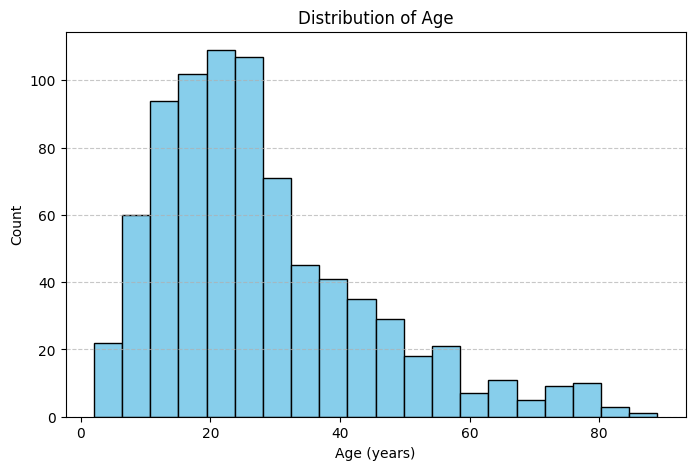

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['age'], bins=20, edgecolor='black', color='skyblue')
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


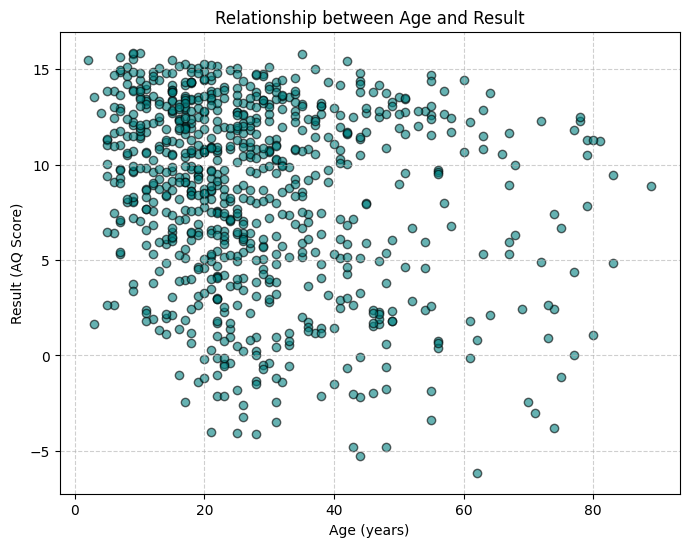

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df['age'], df['result'], alpha=0.6, color='teal', edgecolors='k')
plt.xlabel("Age (years)")
plt.ylabel("Result (AQ Score)")
plt.title("Relationship between Age and Result")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [26]:
# Example: check the mapping for gender
print(encoders['gender'].classes_) #0 is female and 1 is male


['f' 'm']


<Axes: xlabel='gender'>

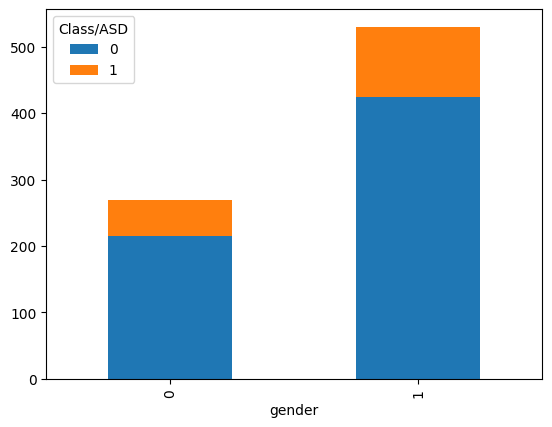

In [27]:
pd.crosstab(df['gender'], df['Class/ASD']).plot(kind='bar', stacked=True)


<Axes: xlabel='Class/ASD', ylabel='result'>

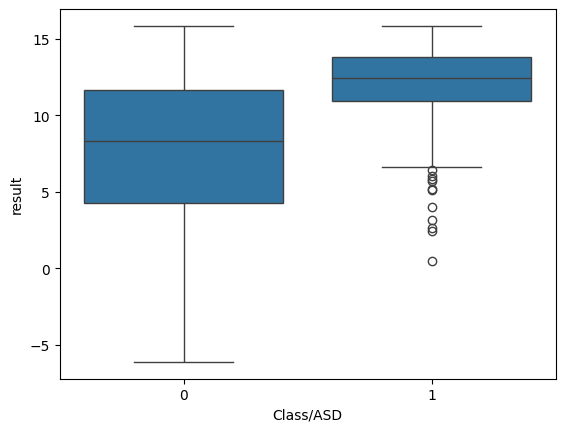

In [28]:
import seaborn as sns
sns.boxplot(x='Class/ASD', y='result', data=df)


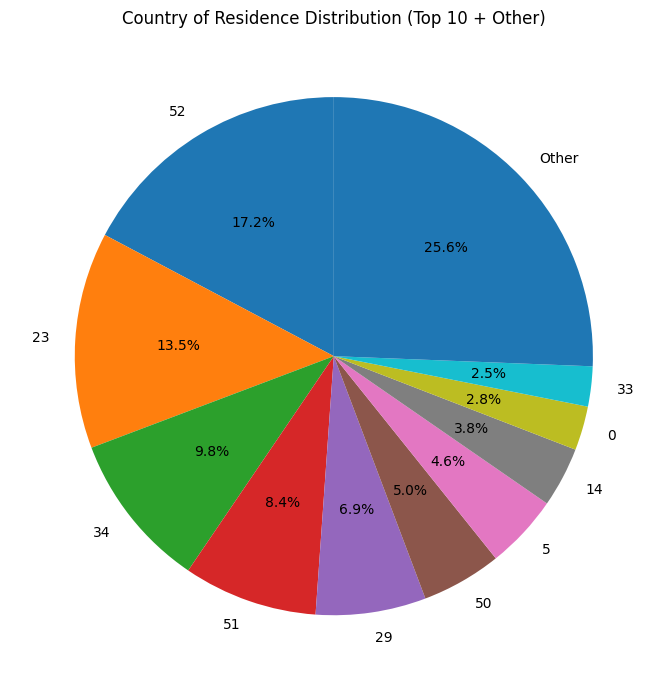

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Get top 10 countries, group the rest as 'Other'
top_n = 10
country_counts = df['contry_of_res'].value_counts()
top_countries = country_counts.head(top_n)
other = pd.Series({'Other': country_counts.iloc[top_n:].sum()})
country_counts = pd.concat([top_countries, other])

# Pie chart
plt.figure(figsize=(7,7))
plt.pie(country_counts.values, labels=country_counts.index,
        autopct='%1.1f%%', startangle=90)
plt.title("Country of Residence Distribution (Top 10 + Other)")
plt.tight_layout()
plt.show()


In [30]:
print(encoders['contry_of_res'].classes_)

['Afghanistan' 'Angola' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bangladesh' 'Belgium' 'Bolivia'
 'Brazil' 'Burundi' 'Canada' 'China' 'Cyprus' 'Czech Republic' 'Egypt'
 'Ethiopia' 'France' 'Germany' 'Iceland' 'India' 'Iran' 'Iraq' 'Ireland'
 'Italy' 'Japan' 'Jordan' 'Kazakhstan' 'Malaysia' 'Mexico' 'Netherlands'
 'New Zealand' 'Nicaragua' 'Niger' 'Oman' 'Pakistan' 'Romania' 'Russia'
 'Saudi Arabia' 'Serbia' 'Sierra Leone' 'South Africa' 'Spain' 'Sri Lanka'
 'Sweden' 'Tonga' 'Ukraine' 'United Arab Emirates' 'United Kingdom'
 'United States' 'Vietnam']


In [31]:
# Gender vs ASD
gender_ct = pd.crosstab(df['gender'], df['Class/ASD'])
print("Gender vs ASD:\n", gender_ct)

# Ethnicity vs ASD
ethnicity_ct = pd.crosstab(df['ethnicity'], df['Class/ASD'])
print("\nEthnicity vs ASD:\n", ethnicity_ct)


Gender vs ASD:
 Class/ASD    0    1
gender             
0          215   55
1          424  106

Ethnicity vs ASD:
 Class/ASD    0    1
ethnicity          
0           63    4
1           41    6
2            7    2
3           13    4
4           91    6
5          226    9
6           26    6
7           31    3
8            5    0
9          136  121


In [32]:
print(encoders['ethnicity'].classes_)

['Asian' 'Black' 'Hispanic' 'Latino' 'Middle Eastern ' 'Others' 'Pasifika'
 'South Asian' 'Turkish' 'White-European']


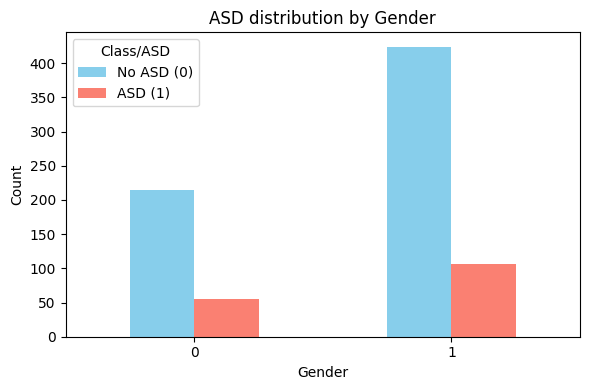

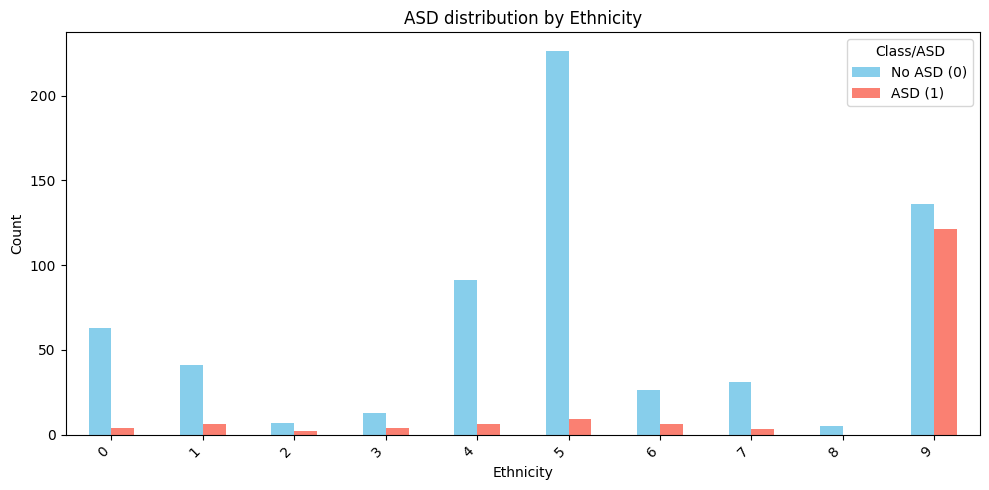

In [33]:
import matplotlib.pyplot as plt

# --- Gender vs ASD ---
gender_ct.plot(kind="bar", stacked=False, figsize=(6,4), color=["skyblue","salmon"])
plt.title("ASD distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Class/ASD", labels=["No ASD (0)", "ASD (1)"])
plt.tight_layout()
plt.show()

# --- Ethnicity vs ASD ---
ethnicity_ct.plot(kind="bar", stacked=False, figsize=(10,5), color=["skyblue","salmon"])
plt.title("ASD distribution by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Class/ASD", labels=["No ASD (0)", "ASD (1)"])
plt.tight_layout()
plt.show()


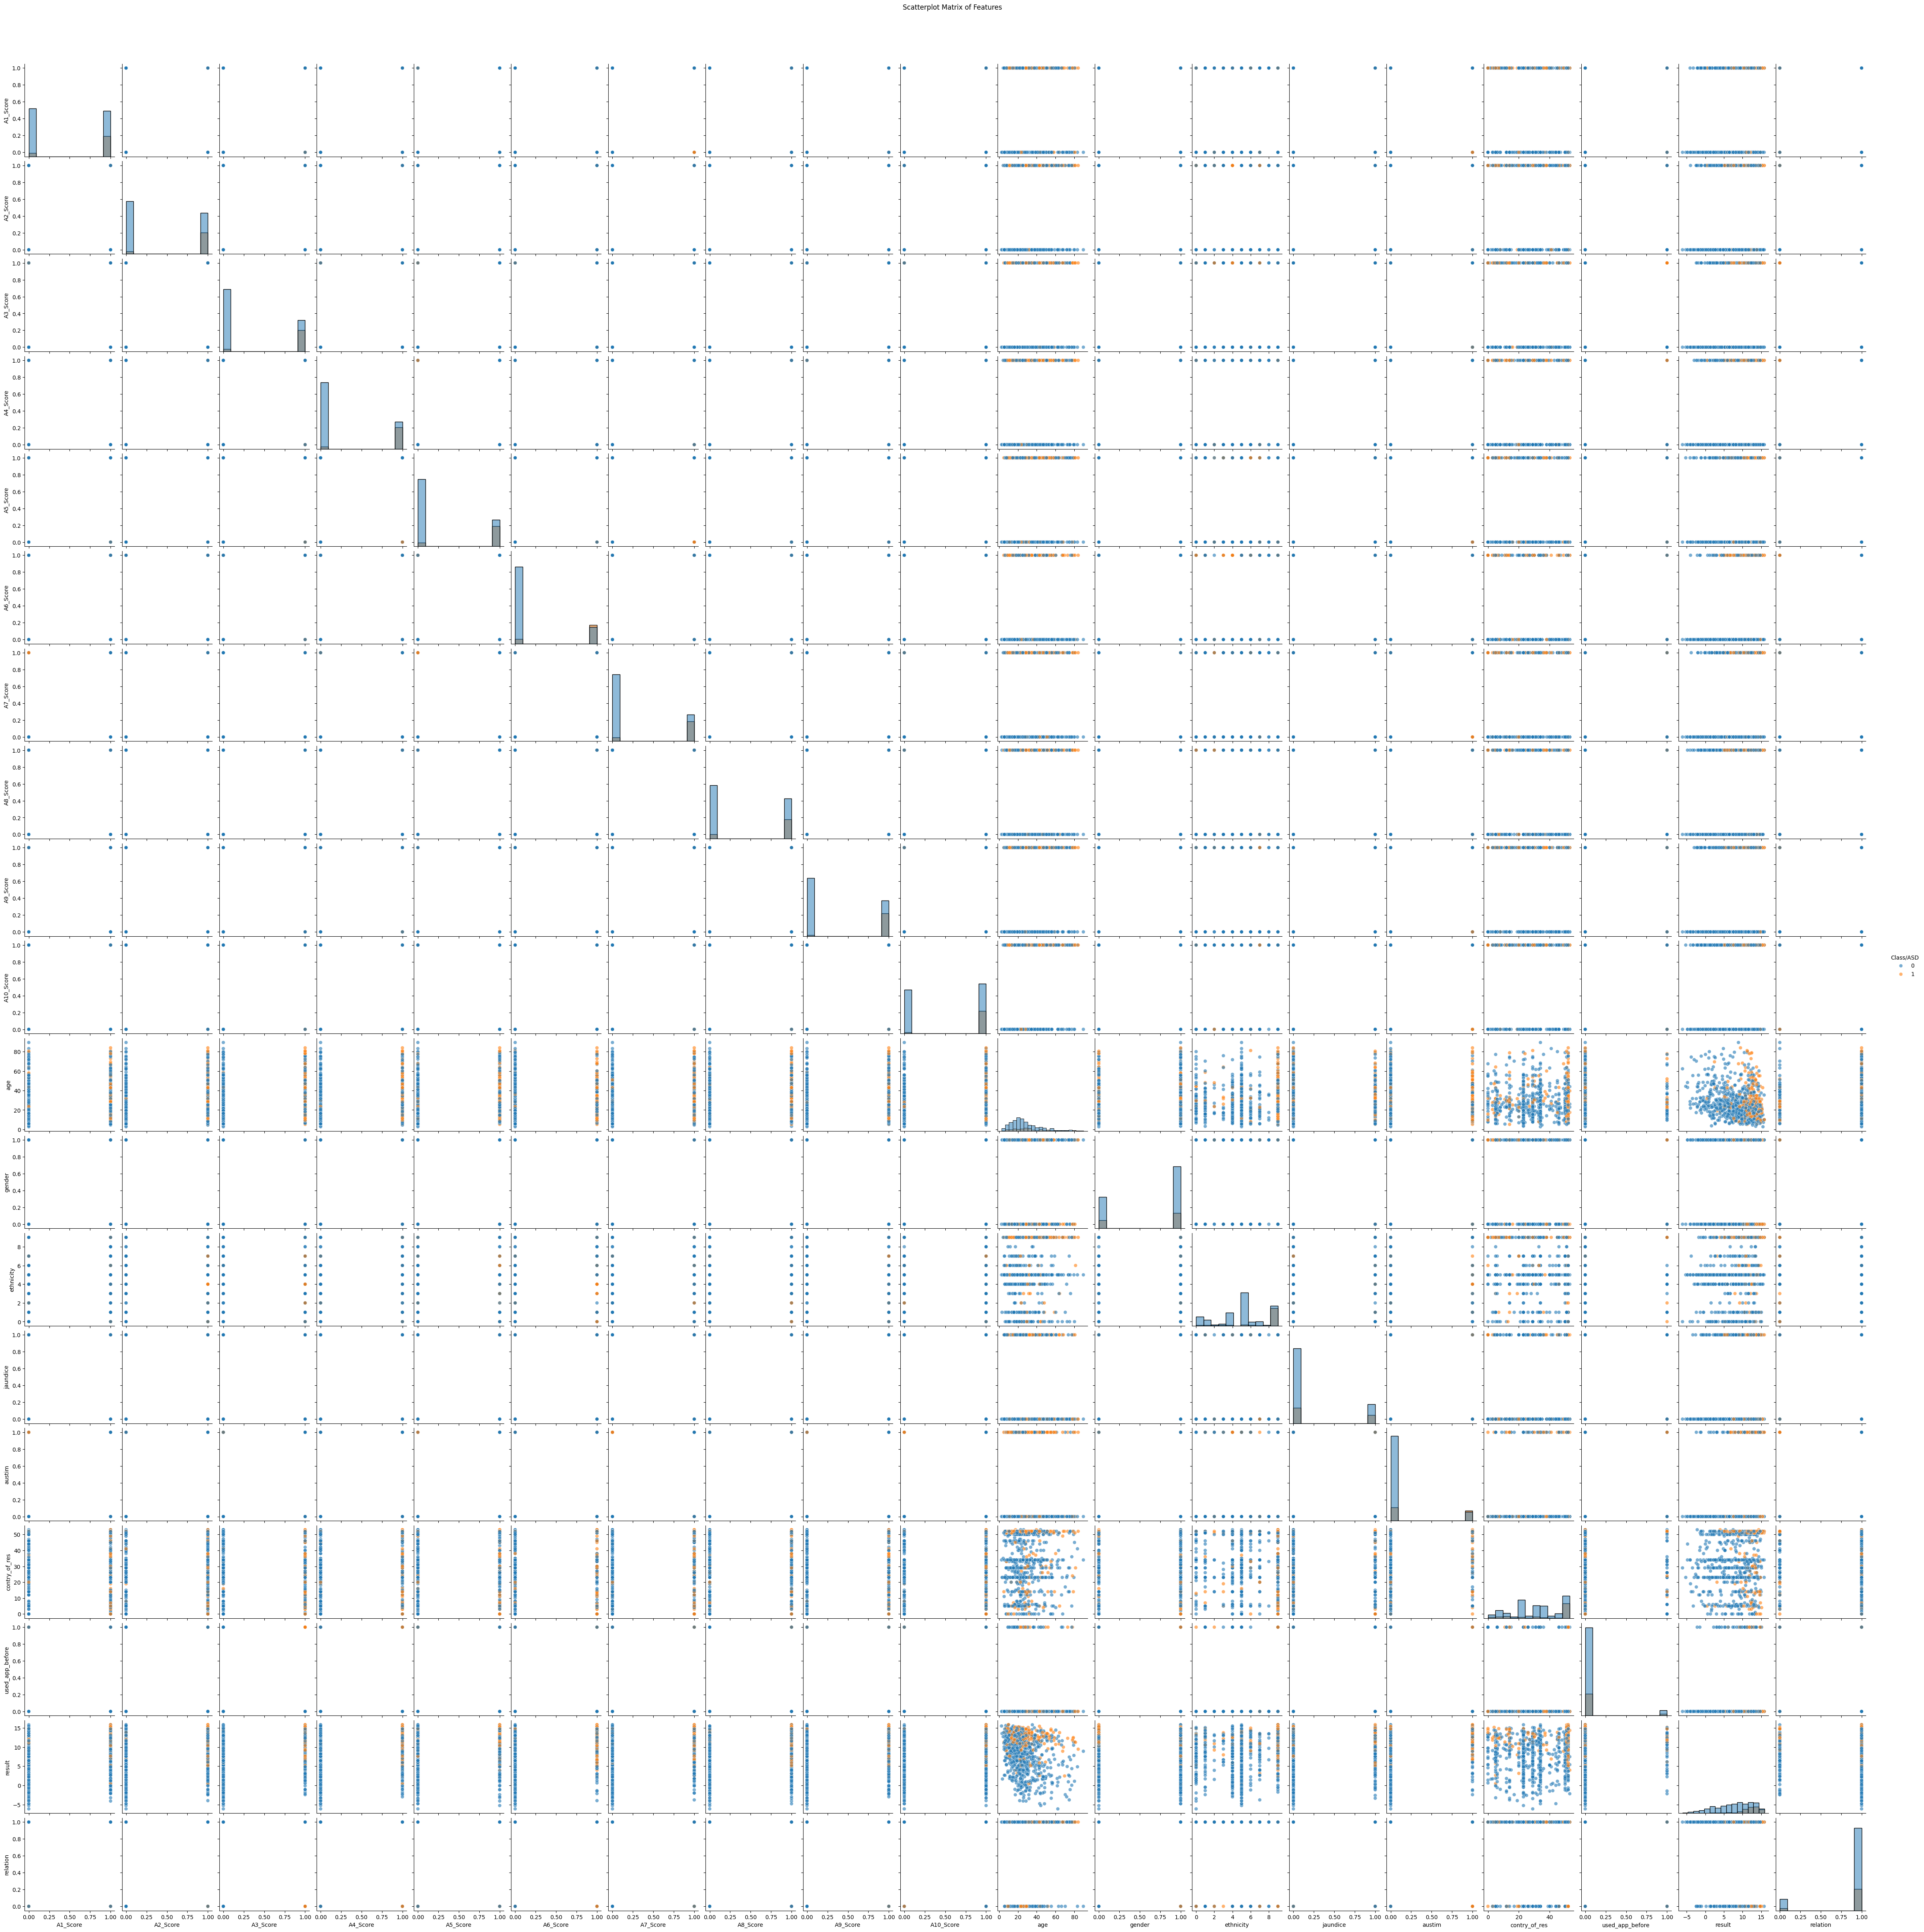

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features + target
numeric_df = df.select_dtypes(include=['int64','float64'])

# Scatterplot matrix (pairplot)
sns.pairplot(numeric_df, hue='Class/ASD', diag_kind='hist',
             plot_kws={'alpha':0.6, 's':40})
plt.suptitle("Scatterplot Matrix of Features", y=1.02)
plt.show()


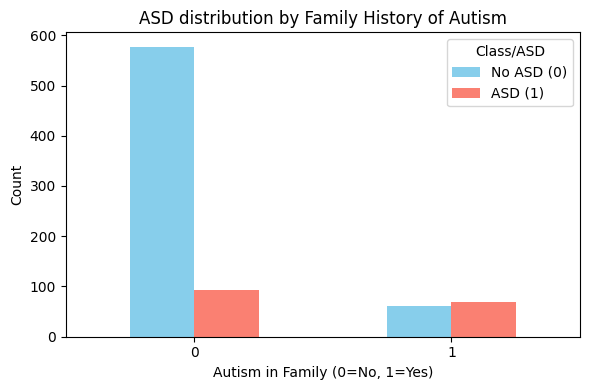

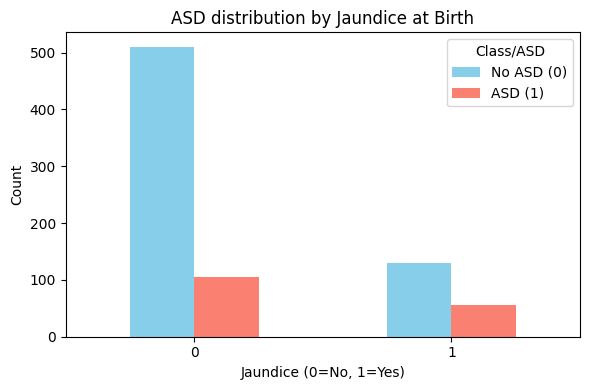

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Crosstabs
autism_ct = pd.crosstab(df['austim'], df['Class/ASD'])
jaundice_ct = pd.crosstab(df['jaundice'], df['Class/ASD'])

# --- Autism vs ASD ---
autism_ct.plot(kind='bar', stacked=False, figsize=(6,4), color=['skyblue','salmon'])
plt.title("ASD distribution by Family History of Autism")
plt.xlabel("Autism in Family (0=No, 1=Yes)")
plt.ylabel("Count")
plt.legend(title="Class/ASD", labels=["No ASD (0)", "ASD (1)"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Jaundice vs ASD ---
jaundice_ct.plot(kind='bar', stacked=False, figsize=(6,4), color=['skyblue','salmon'])
plt.title("ASD distribution by Jaundice at Birth")
plt.xlabel("Jaundice (0=No, 1=Yes)")
plt.ylabel("Count")
plt.legend(title="Class/ASD", labels=["No ASD (0)", "ASD (1)"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


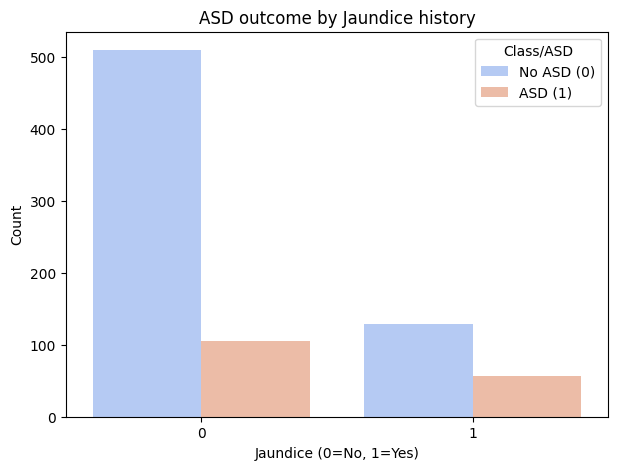

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.countplot(data=df, x='jaundice', hue='Class/ASD', palette='coolwarm',
              order=[0,1])  # ensure 0=no, 1=yes
plt.title("ASD outcome by Jaundice history")
plt.xlabel("Jaundice (0=No, 1=Yes)")
plt.ylabel("Count")
plt.legend(title="Class/ASD", labels=["No ASD (0)", "ASD (1)"])
plt.show()


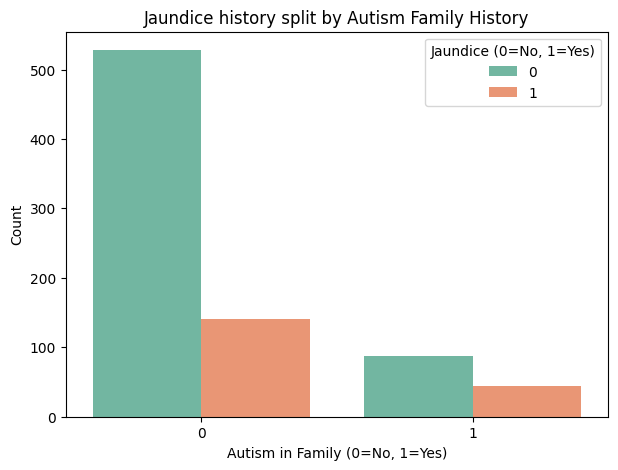

In [36]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='austim', hue='jaundice', palette='Set2',
              order=[0,1])
plt.title("Jaundice history split by Autism Family History")
plt.xlabel("Autism in Family (0=No, 1=Yes)")
plt.ylabel("Count")
plt.legend(title="Jaundice (0=No, 1=Yes)")
plt.show()


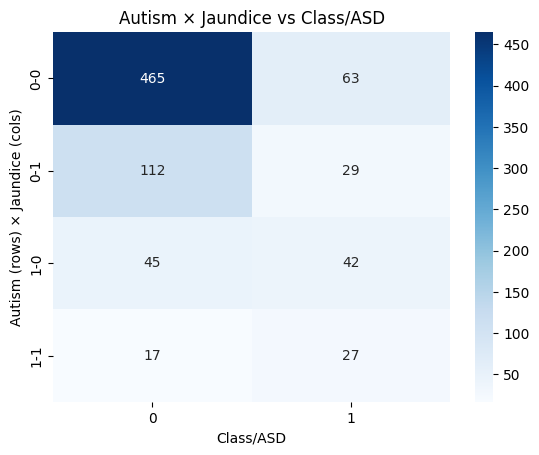

In [37]:
ct = pd.crosstab([df['austim'], df['jaundice']], df['Class/ASD'])
sns.heatmap(ct, annot=True, fmt='d', cmap="Blues")
plt.title("Autism × Jaundice vs Class/ASD")
plt.xlabel("Class/ASD")
plt.ylabel("Autism (rows) × Jaundice (cols)")
plt.show()


In [38]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Features and target
X = df[['result', 'austim', 'jaundice']]
y = df['Class/ASD']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define and fit the model
logr = linear_model.LogisticRegression(max_iter=1000)
logr.fit(X_train, y_train)

# Example prediction: result=12, autism=1, jaundice=0
# sample = np.array([[12, 1, 0]])
# predicted = logr.predict(sample)
# print("Predicted Class/ASD:", predicted)

# Confusion matrix and accuracy
y_pred = logr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy:", acc)


Confusion Matrix:
 [[180   6]
 [ 37  17]]
Accuracy: 0.8208333333333333


In [39]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load dataset
# df = pd.read_csv("train.csv")

# Features and target
X = df[['result', 'austim', 'jaundice']]
y = df['Class/ASD']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit logistic regression
logr = LogisticRegression(max_iter=1000)
logr.fit(X_train, y_train)

# ---- Custom logit to probability function ----
def logit2prob(model, X_input):
    """
    Convert logit (linear output) to probability for Logistic Regression
    """
    coef = np.dot(X_input, model.coef_.T) + model.intercept_   # linear combination
    odds = np.exp(coef)                                        # exponentiate
    prob = odds / (1 + odds)                                   # logistic function
    return prob

# Example: compute probability for multiple rows from X_test
sample = X_test.head(50).values   # first 5 test samples
probs = logit2prob(logr, sample)

print("Input values:\n", X_test.head(50))
print("\nProbabilities of ASD=1:\n", probs)


Input values:
         result  austim  jaundice
696  13.332323       0         0
667   6.479508       0         0
63   14.772424       0         0
533   9.656317       0         0
66    1.388938       0         0
621   8.378231       0         1
346  10.631007       0         0
490  11.518279       1         0
760  12.462061       1         0
456  12.695195       0         0
65   13.067098       1         1
286  11.535109       0         0
635   0.015734       0         0
67    3.971814       0         0
327  12.286130       0         1
395   2.596200       0         1
244   3.778064       0         0
377  10.672868       0         0
610   6.212423       0         1
526  12.167011       1         0
658   9.875047       0         0
529  -0.115811       0         0
622  11.429835       0         0
721  12.329555       0         0
360  15.474665       1         1
30   13.189531       0         0
260  11.688423       0         0
637   6.459334       0         0
746  -1.852079       0      

# **Logistic Regression and Confusion matrix on Full Training Data **

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


# Define features (X) and target (y)
X = df[['result', 'austim', 'jaundice']]
y = df['Class/ASD']

# Define and fit logistic regression model
model = LogisticRegression(solver='liblinear', C=10, random_state=0, max_iter=1000)
model.fit(X, y)

# Predictions
y_pred = model.predict(X)           # predicted classes
p_pred = model.predict_proba(X)     # predicted probabilities

# Evaluation
accuracy = model.score(X, y)        # accuracy
conf_m = confusion_matrix(y, y_pred)

# Output
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_m)
print("\nPredicted Probabilities (first 10 rows):\n", p_pred[:10])
print("\nClassification Report:\n", classification_report(y, y_pred))


Accuracy: 0.8225
Confusion Matrix:
 [[604  35]
 [107  54]]

Predicted Probabilities (first 10 rows):
 [[0.93530984 0.06469016]
 [0.97367888 0.02632112]
 [0.33300366 0.66699634]
 [0.97355261 0.02644739]
 [0.99464127 0.00535873]
 [0.87378138 0.12621862]
 [0.90859808 0.09140192]
 [0.41956879 0.58043121]
 [0.98934118 0.01065882]
 [0.57567446 0.42432554]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.89       639
           1       0.61      0.34      0.43       161

    accuracy                           0.82       800
   macro avg       0.73      0.64      0.66       800
weighted avg       0.80      0.82      0.80       800



**Logistic Regression and Confusion matrix on Test Data **


In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Features (X) and target (y)
X = df[['result', 'austim', 'jaundice']]
y = df['Class/ASD']

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Define and fit logistic regression model
model = LogisticRegression(solver='liblinear', C=10, random_state=0, max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)           # predicted classes
p_pred = model.predict_proba(X_test)     # predicted probabilities

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)

# Output
print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_m)
print("\nPredicted Probabilities (first 10 rows):\n", p_pred[:10])
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))


Test Accuracy: 0.8041666666666667
Confusion Matrix:
 [[176  16]
 [ 31  17]]

Predicted Probabilities (first 10 rows):
 [[0.9742376  0.0257624 ]
 [0.98829478 0.01170522]
 [0.7114253  0.2885747 ]
 [0.46772951 0.53227049]
 [0.51040672 0.48959328]
 [0.87518582 0.12481418]
 [0.42545456 0.57454544]
 [0.79003187 0.20996813]
 [0.87763766 0.12236234]
 [0.79011059 0.20988941]]

Classification Report:
               precision    recall  f1-score   support

           0      0.850     0.917     0.882       192
           1      0.515     0.354     0.420        48

    accuracy                          0.804       240
   macro avg      0.683     0.635     0.651       240
weighted avg      0.783     0.804     0.790       240



In [42]:
from sklearn.linear_model import LogisticRegression

X = df[['result', 'austim', 'jaundice']]
y = df['Class/ASD']

logr = LogisticRegression(max_iter=1000)
logr.fit(X, y)

print("Intercept (b0):", logr.intercept_[0])
print("Coefficients (b1, b2, b3):", logr.coef_[0])


Intercept (b0): -4.176216730450171
Coefficients (b1, b2, b3): [0.23513018 1.35584219 0.38849478]


logit(p)=−4.1762+0.2351⋅result+1.3558⋅austim+0.3885⋅jaundice

Interpretation:

Each 1-point increase in result increases the log-odds of ASD by 0.2351.

Having a family history of autism (austim=1) increases the log-odds by 1.3558.

Having jaundice at birth increases the log-odds by 0.3885.

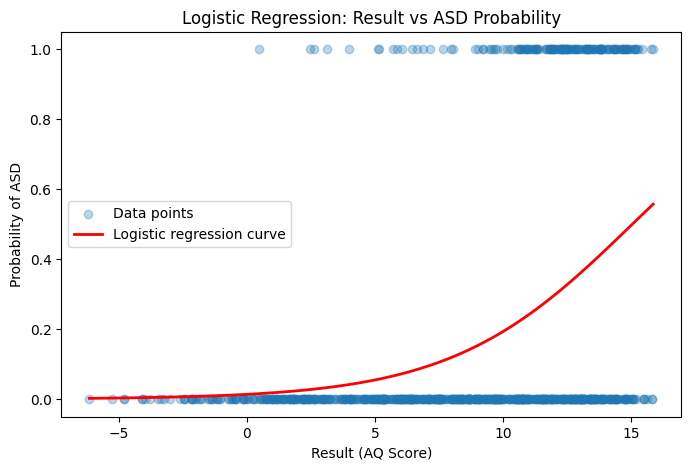

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Features (use only 'result' for visualization) and target
X = df[['result']].values
y = df['Class/ASD'].values

# Fit logistic regression
logr = LogisticRegression(max_iter=1000)
logr.fit(X, y)

# Generate range of result values for smooth curve
X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_prob = logr.predict_proba(X_range)[:, 1]  # probability of ASD=1

# Plot
plt.figure(figsize=(8,5))
plt.scatter(X, y, alpha=0.3, label="Data points")
plt.plot(X_range, y_prob, color='red', linewidth=2, label="Logistic regression curve")
plt.xlabel("Result (AQ Score)")
plt.ylabel("Probability of ASD")
plt.title("Logistic Regression: Result vs ASD Probability")
plt.legend()
plt.show()


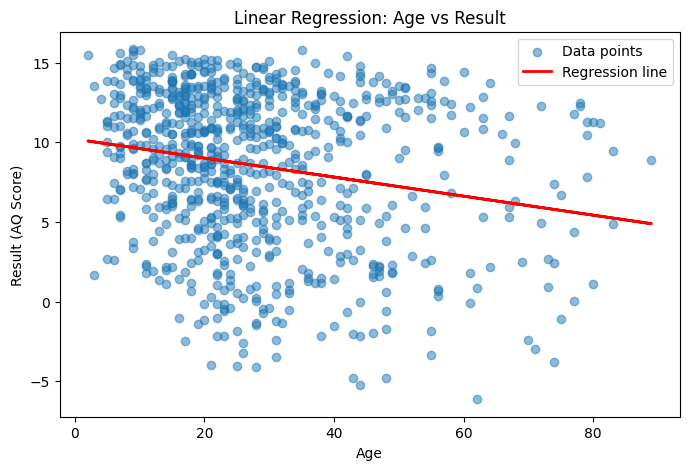

Coefficient (a): -0.059765634966058356
Intercept (b): 10.208574381283363
Equation: y = -0.0598 * Age + 10.2086


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# Features (age) and target (result)
X = df[['age']]
y = df['result']

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X, y)

# Predictions
y_pred = linreg.predict(X)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(X, y, alpha=0.5, label="Data points")
plt.plot(X, y_pred, color='red', linewidth=2, label="Regression line")
plt.xlabel("Age")
plt.ylabel("Result (AQ Score)")
plt.title("Linear Regression: Age vs Result")
plt.legend()
plt.show()

# Print equation
print("Coefficient (a):", linreg.coef_[0])
print("Intercept (b):", linreg.intercept_)
print(f"Equation: y = {linreg.coef_[0]:.4f} * Age + {linreg.intercept_:.4f}")


In [58]:
X = df[['result', 'austim']]
y = df['Class/ASD']

print(X.head())
print(y.head())


      result  austim
0   6.351166       0
1   2.255185       0
2  14.851484       1
3   2.276617       0
4  -4.777286       0
0    0
1    0
2    1
3    0
4    0
Name: Class/ASD, dtype: int64


In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (640, 2)
Test shape : (160, 2)


In [60]:
# Import everything required for KNN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


KNN accuracy: 0.7688


<Figure size 640x480 with 0 Axes>

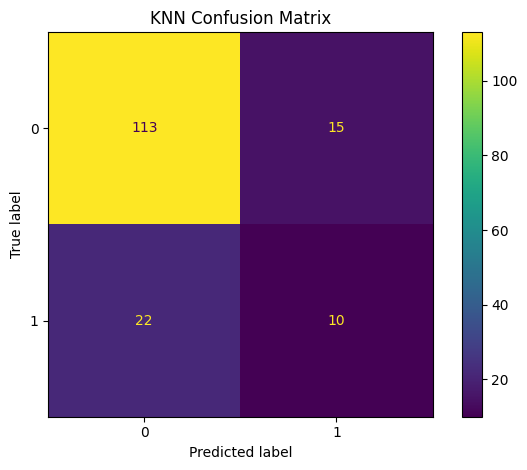

In [61]:
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=5))
])

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"KNN accuracy: {acc_knn:.4f}")

plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.savefig("knn_confusion.png", dpi=200)
plt.show()


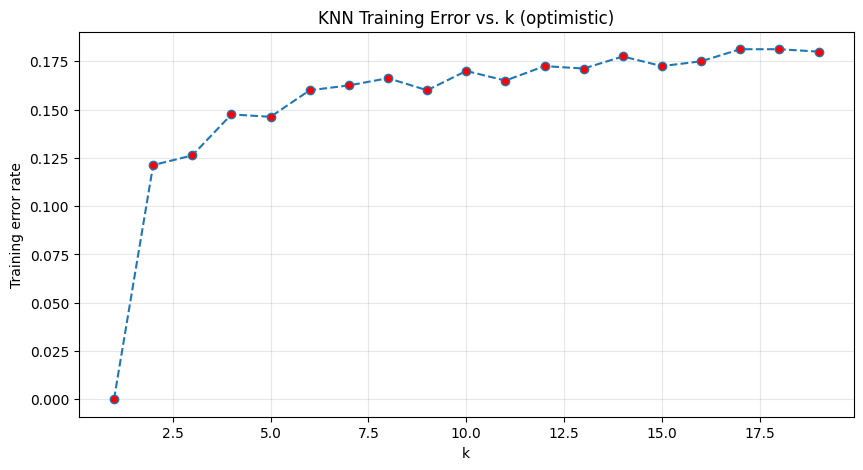

In [66]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# define x, y first (use your actual DataFrame)
# X = df[['result','austim']].values
# y = df['Class/ASD'].values
x = X.values  # assuming X already defined as above
y = y.values  # assuming y already defined as above

SSE = []  # really "error rate", not SSE
for k in range(1, 20):
    if k > len(x):
        break  # guard: k cannot exceed number of samples
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x, y)
    pred_i = knn.predict(x)  # <- training set (optimistic)
    SSE.append(np.mean(pred_i != y))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 1 + len(SSE)), SSE, linestyle='dashed', marker='o', markerfacecolor='r')
plt.xlabel("k")
plt.ylabel("Training error rate")
plt.title("KNN Training Error vs. k (optimistic)")
plt.grid(True, alpha=0.3)
plt.show()

In [62]:
# Import everything needed for Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


Naive Bayes accuracy: 0.7937


<Figure size 640x480 with 0 Axes>

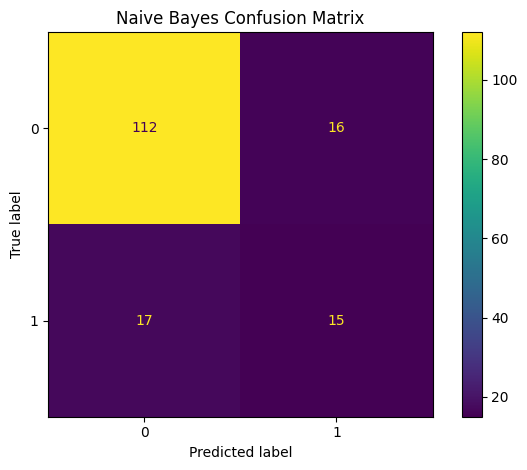

In [63]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

print(f"Naive Bayes accuracy: {acc_nb:.4f}")

plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb)
plt.title("Naive Bayes Confusion Matrix")
plt.tight_layout()
plt.savefig("nb_confusion.png", dpi=200)
plt.show()


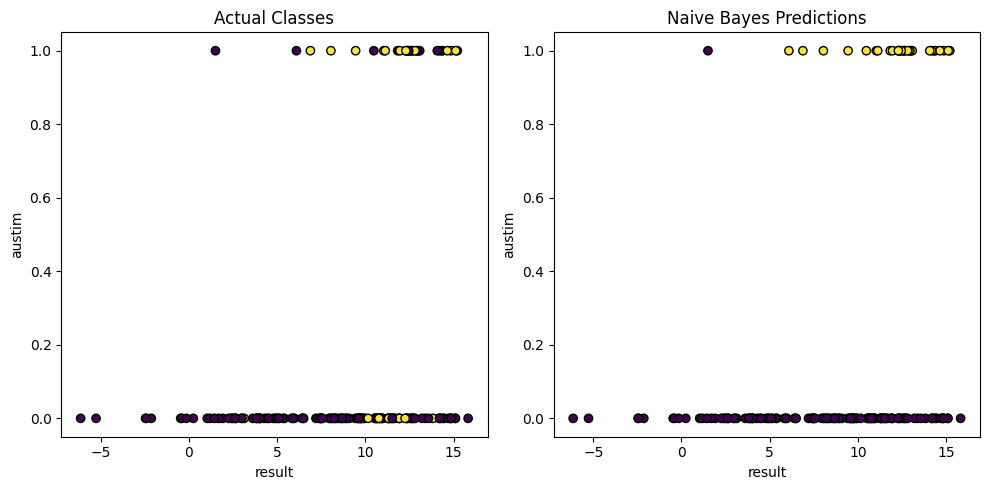

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Actual classes
ax[0].scatter(X_test['result'], X_test['austim'], c=y_test, cmap='viridis', edgecolor='k')
ax[0].set_title("Actual Classes")
ax[0].set_xlabel("result")
ax[0].set_ylabel("austim")

# Predicted classes
ax[1].scatter(X_test['result'], X_test['austim'], c=y_pred_nb, cmap='viridis', edgecolor='k')
ax[1].set_title("Naive Bayes Predictions")
ax[1].set_xlabel("result")
ax[1].set_ylabel("austim")

plt.tight_layout()
plt.savefig("nb_actual_vs_predicted.png", dpi=200)
plt.show()


In [53]:
if acc_knn > acc_nb:
    better = "KNN"
elif acc_nb > acc_knn:
    better = "Naive Bayes"
else:
    better = "Tie"

print("Summary:")
print(f"KNN accuracy       : {acc_knn:.4f}")
print(f"Naive Bayes accuracy: {acc_nb:.4f}")
print(f"Better model        : {better}")


Summary:
KNN accuracy       : 0.7688
Naive Bayes accuracy: 0.7937
Better model        : Naive Bayes
